#  Traffic Crash Cause Prediction

## Overview
This project aims to build a machine learning classifier that predicts the **primary contributory cause** of a car accident based on available data about:
- Road and environmental conditions
- Vehicle information
- People involved in the crash

The goal is to assist stakeholders such as the **Vehicle Safety Board** or the **City of Chicago** in identifying and addressing key factors contributing to traffic accidents.


### Problem Statement
The target variable (`PRIM_CONTRIBUTORY_CAUSE`) contains many categories, some of which have very few observations. To build a reliable model:
- I **limited the number of target categories** by focusing on the most frequent causes
- Rare categories were either grouped into an "Other" class or excluded to avoid overfitting

---

##  Data Sources

1. `Traffic Crashes - Crashes.csv`: Main crash dataset
2. `Traffic Crashes - Vehicles.csv`: Vehicle details
3. `Traffic Crashes - People.csv`: Information about drivers/passengers

##  Key Columns
- `CRASH_DATE`, `CRASH_TIME`: Time-based insights
- `WEATHER_CONDITION`, `ROADWAY_SURFACE_COND`, etc.
- `NUM_UNITS`, `INJURIES_TOTAL`, `FATALITIES`
- `PRIM_CONTRIBUTORY_CAUSE`: **Target label**


## Data Loading
In this step, loaded the primary datasets required for our analysis and model building:

**crashes_df**: Contains detailed records of reported traffic crashes in Chicago.

**vehicles_df**: Contains information about vehicles involved in each crash.

**people_df**: Contains details about the individuals involved, such as drivers and passengers.

These datasets will later be merged and preprocessed to build a predictive model for identifying the primary contributory cause of a crash.

In [5]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

# Load the datasets
crashes_df=pd.read_csv( './data/Traffic_Crashes_-_Crashes_20250605.csv')
vehicles_df=pd.read_csv( './data/Traffic_Crashes_-_Vehicles_20250605.csv',)
people_df=pd.read_csv( './data/Traffic_Crashes_-_People_20250605.csv',)

## Exploring Dataset Structure

Inspecting the structure of our three key datasets:

- `crashes_df`: Contains information related to the crash event, such as date, time, location, and contributing factors.
- `vehicles_df`: Includes data about the vehicles involved in each crash.
- `people_df`: Contains details about the drivers and passengers, including injuries and roles.



In [6]:
# checking info of the dataframes
crashes_df.info()
vehicles_df.info()
people_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH_RECORD_ID                1816 non-null   object 
 1   CRASH_DATE_EST_I               146 non-null    object 
 2   CRASH_DATE                     1816 non-null   object 
 3   POSTED_SPEED_LIMIT             1816 non-null   int64  
 4   TRAFFIC_CONTROL_DEVICE         1816 non-null   object 
 5   DEVICE_CONDITION               1816 non-null   object 
 6   WEATHER_CONDITION              1816 non-null   object 
 7   LIGHTING_CONDITION             1816 non-null   object 
 8   FIRST_CRASH_TYPE               1816 non-null   object 
 9   TRAFFICWAY_TYPE                1816 non-null   object 
 10  LANE_CNT                       403 non-null    float64
 11  ALIGNMENT                      1816 non-null   object 
 12  ROADWAY_SURFACE_COND           1816 non-null   o

###  Checking for Missing Values

To identify data quality issues, I defined a utility function `check_missing_values()` that:

- Computes the total number of missing values in each column of a given DataFrame
- Filters out columns with no missing values for a cleaner view

ApplIied this function to the three datasets: `crashes_df`, `vehicles_df`, and `people_df`.



In [7]:
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    return missing_values
print("Missing values in crashes_df:\n", check_missing_values(crashes_df))
print("Missing values in vehicles_df:\n", check_missing_values(vehicles_df))    
print("Missing values in people_df:\n", check_missing_values(people_df))


Missing values in crashes_df:
 CRASH_DATE_EST_I                 1670
LANE_CNT                         1413
REPORT_TYPE                        60
INTERSECTION_RELATED_I           1421
NOT_RIGHT_OF_WAY_I               1724
HIT_AND_RUN_I                    1206
PHOTOS_TAKEN_I                   1787
STATEMENTS_TAKEN_I               1761
DOORING_I                        1810
WORK_ZONE_I                      1809
WORK_ZONE_TYPE                   1813
WORKERS_PRESENT_I                1814
MOST_SEVERE_INJURY                  4
INJURIES_TOTAL                      4
INJURIES_FATAL                      4
INJURIES_INCAPACITATING             4
INJURIES_NON_INCAPACITATING         4
INJURIES_REPORTED_NOT_EVIDENT       4
INJURIES_UNKNOWN                    4
INJURIES_NO_INDICATION              4
LATITUDE                           17
LONGITUDE                          17
LOCATION                           17
dtype: int64
Missing values in vehicles_df:
 UNIT_TYPE                     3
NUM_PASSENGERS    

## Dropping Columns with More Than 60% Missing Values

To clean the datasets, I defined a function `drop_high_missing_columns` that removes columns with more than 60% missing values. This helps in reducing noise and avoiding biases due to too many null entries.



In [8]:
# DROPPING COLUMNS WITH MORE THAN 6O% MISSING VALUES
def drop_high_missing_columns(df, threshold=0.6):
    missing_percentage = df.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > threshold].index
    df_dropped = df.drop(columns=columns_to_drop)
    print(f"Dropped columns: {columns_to_drop.tolist()}")
    return df_dropped
crashes_df = drop_high_missing_columns(crashes_df)
vehicles_df = drop_high_missing_columns(vehicles_df)    
people_df = drop_high_missing_columns(people_df)




Dropped columns: ['CRASH_DATE_EST_I', 'LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'PHOTOS_TAKEN_I', 'STATEMENTS_TAKEN_I', 'DOORING_I', 'WORK_ZONE_I', 'WORK_ZONE_TYPE', 'WORKERS_PRESENT_I']
Dropped columns: ['NUM_PASSENGERS', 'CMRC_VEH_I', 'TOWED_I', 'FIRE_I', 'EXCEED_SPEED_LIMIT_I', 'TOWED_BY', 'TOWED_TO', 'AREA_00_I', 'AREA_01_I', 'AREA_02_I', 'AREA_03_I', 'AREA_04_I', 'AREA_05_I', 'AREA_06_I', 'AREA_07_I', 'AREA_08_I', 'AREA_09_I', 'AREA_10_I', 'AREA_11_I', 'AREA_12_I', 'AREA_99_I', 'CMV_ID', 'USDOT_NO', 'CCMC_NO', 'ILCC_NO', 'COMMERCIAL_SRC', 'GVWR', 'CARRIER_NAME', 'CARRIER_STATE', 'CARRIER_CITY', 'HAZMAT_PLACARDS_I', 'HAZMAT_NAME', 'UN_NO', 'HAZMAT_PRESENT_I', 'HAZMAT_REPORT_I', 'HAZMAT_REPORT_NO', 'MCS_REPORT_I', 'MCS_REPORT_NO', 'HAZMAT_VIO_CAUSE_CRASH_I', 'MCS_VIO_CAUSE_CRASH_I', 'IDOT_PERMIT_NO', 'WIDE_LOAD_I', 'TRAILER1_WIDTH', 'TRAILER2_WIDTH', 'TRAILER1_LENGTH', 'TRAILER2_LENGTH', 'TOTAL_VEHICLE_LENGTH', 'AXLE_CNT', 'VEHICLE_CONFIG', 'CARGO_

###  Reviewing Remaining Columns After Cleaning

After removing columns that were either irrelevant or had too many missing values, I printed the remaining columns in each dataset. This helped me confirm the features I still have available for modeling and analysis.



In [9]:
# remaining columns after dropping
print("Remaining columns in crashes_df:", crashes_df.columns.tolist())
print("Remaining columns in vehicles_df:", vehicles_df.columns.tolist())
print("Remaining columns in people_df:", people_df.columns.tolist())


Remaining columns in crashes_df: ['CRASH_RECORD_ID', 'CRASH_DATE', 'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE', 'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED', 'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_UNKNOWN', 'INJURIES_NO_INDICATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH', 'LATITUDE', 'LONGITUDE', 'LOCATION']
Remaining columns in vehicles_df: ['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE', 'UNIT_NO', 'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE', 'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE', 'TRAVEL_DIRECTION', 'MANEU

##  Handling Missing Values
To ensure data quality and model readiness, missing values in the datasets were addressed using a custom imputation strategy:

**Numeric Columns:**
For each numeric column, missing values were filled using either the mean or median. The choice depended on the skewness of the column — if the data was approximately symmetric, the mean was used; otherwise, the median was chosen to reduce the influence of outliers.

**Categorical Columns:**
Missing values were filled using the most frequent value (mode) in each column. In cases where no mode could be determined, a placeholder value such as "Unknown" was used.

This strategy ensures that missing data does not distort the training process while preserving the underlying distribution of each feature.

In [10]:
def fill_missing(df):
# Filling missing values in numeric columns
    for col in df.select_dtypes(include=['number']).columns:
        if df[col].isna().sum() > 0:
            skewness = df[col].skew()
            fill_value = df[col].mean() if abs(skewness) < 0.5 else df[col].median()
            df[col] = df[col].fillna(fill_value)  # Corrected line

    # Filling missing values in categorical columns
    for col in df.select_dtypes(exclude=['number']).columns:
        if df[col].isna().sum() > 0:
            most_frequent = df[col].mode()[0] if not df[col].mode().empty else "Unknown"
            df[col] = df[col].fillna(most_frequent)  # Corrected line

    return df
# Filling missing values in each DataFrame
crashes_df = fill_missing(crashes_df)
vehicles_df = fill_missing(vehicles_df)
people_df = fill_missing(people_df)

##  Merging the Datasets
To consolidate all relevant data into a single dataset for modeling, the three individual datasets were merged as follows:

## Merging Vehicles and People:
The vehicles_df and people_df datasets were merged on the common columns CRASH_RECORD_ID and VEHICLE_ID using an inner join. This ensured that only records with matching vehicle and person entries were retained.

## Combining with Crashes Data:
The merged vehicles-persons data was then merged with the crashes_df dataset on CRASH_RECORD_ID, again using an inner join. This step brought in contextual crash information for each person-vehicle record.

The result was a comprehensive full_data dataset, capturing person-level, vehicle-level, and crash-level attributes for each incident, ready for preprocessing and modeling.



In [11]:
# Merge Vehicles and Persons on CRASH_RECORD_ID and VEHICLE_ID
vehicles_persons = pd.merge(vehicles_df, people_df, on=['CRASH_RECORD_ID', 'VEHICLE_ID'], how='inner')

# Merge above with Crashes on CRASH_RECORD_ID
full_data = pd.merge(vehicles_persons,crashes_df, on='CRASH_RECORD_ID', how='inner')


## Checking for Duplicate Records
Duplicate rows in the dataset can bias the model and inflate performance metrics. To ensure data integrity, the merged dataset was checked for duplicate records.

The number of duplicate rows was counted using a standard duplicate detection method.

Identifying duplicates helps in deciding whether to remove or further investigate these entries.

This step ensures that the dataset used for modeling is clean and free of redundant information.

In [12]:
#check duplicates on the merged DataFrame
def check_duplicates(df):
    duplicates = df.duplicated().sum()
    return duplicates
print("Number of duplicate rows in full_data:", check_duplicates(full_data))

Number of duplicate rows in full_data: 0


## Feature Engineering
To enhance the predictive power of the model, several new features were created from existing data:

**Temporal Features:**

**IS_WEEKEND:** Indicates if the crash occurred on a weekend (Saturday or Sunday).

**IS_NIGHT:** Flags crashes that happened during night hours (before 6 AM or after 8 PM).

**IS_RUSH_HOUR:** Identifies crashes occurring during typical morning and evening rush hours.

## Injury Indicators:

**HAS_FATAL_INJURY:** Boolean flag indicating if any fatal injuries occurred.

**HAS_INJURY:** Boolean flag indicating if any injuries occurred.

## Traffic Control Conditions:

**BAD_DEVICE_COND:** Flags crashes where traffic control devices were missing or unknown.

**NO_TRAFFIC_CONTROL:** Flags crashes where no traffic control devices were present.

These features capture important contextual information related to time of day, severity, and traffic conditions, which can improve classification performance.

In [13]:
full_data['CRASH_DATE'] = pd.to_datetime(full_data['CRASH_DATE'], errors='coerce')
full_data['IS_WEEKEND'] = full_data['CRASH_DATE'].dt.dayofweek >= 5
full_data['IS_NIGHT'] = full_data['CRASH_HOUR'].apply(lambda x: 1 if x < 6 or x > 20 else 0)
full_data['IS_RUSH_HOUR'] = full_data['CRASH_HOUR'].apply(lambda x: 1 if 7 <= x <= 9 or 16 <= x <= 18 else 0)
full_data['HAS_FATAL_INJURY'] = full_data['INJURIES_FATAL'] > 0
full_data['HAS_INJURY'] = full_data['INJURIES_TOTAL'] > 0
full_data['BAD_DEVICE_COND'] = full_data['DEVICE_CONDITION'].isin(['NO CONTROLS', 'UNKNOWN'])
full_data['NO_TRAFFIC_CONTROL'] = full_data['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS'




C:\Users\hezronkatila\AppData\Local\Temp\ipykernel_12772\568436380.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  full_data['CRASH_DATE'] = pd.to_datetime(full_data['CRASH_DATE'], errors='coerce')


## Location Clustering with K-Means
To incorporate spatial information without using raw latitude and longitude values directly, K-Means clustering was applied:

Objective: Group crash locations into clusters representing distinct geographic areas.

**Method:**

Latitude and longitude coordinates were used to form 10 clusters.

Each crash record is assigned a LOCATION_CLUSTER label indicating its cluster membership.

This spatial clustering helps capture location-based patterns or hotspots that may influence accident causes, improving the model’s contextual awarenes

In [14]:
from sklearn.cluster import KMeans

coords = full_data[['LATITUDE', 'LONGITUDE']].dropna()
kmeans = KMeans(n_clusters=10, random_state=42)
full_data.loc[coords.index, 'LOCATION_CLUSTER'] = kmeans.fit_predict(coords)


## Binning Rare Categories
To reduce noise and dimensionality caused by infrequent categories, rare classes in certain categorical features were grouped into a common category labeled "Other":

Features Processed:

WEATHER_CONDITION

FIRST_CRASH_TYPE

TRAFFIC_CONTROL_DEVICE

**Method:**
Categories representing less than 1% of occurrences were replaced with "Other".

This approach helps prevent overfitting and improves model generalization by focusing on more significant category groups.



In [15]:
def bin_rare(series, threshold=0.01):
    freq = series.value_counts(normalize=True)
    rare = freq[freq < threshold].index
    return series.apply(lambda x: 'Other' if x in rare else x)

full_data['WEATHER_CONDITION'] = bin_rare(full_data['WEATHER_CONDITION'])
full_data['FIRST_CRASH_TYPE'] = bin_rare(full_data['FIRST_CRASH_TYPE'])
full_data['TRAFFIC_CONTROL_DEVICE'] = bin_rare(full_data['TRAFFIC_CONTROL_DEVICE'])


## Selecting Features for Modeling
After data cleaning and feature engineering, the next step is to review and select the most relevant columns for building the classification model.

Focused on columns that have predictive value and avoid those that leak target information or are redundant.

Columns related to identifiers (CRASH_RECORD_ID, VEHICLE_ID, etc.) and high-cardinality text fields (e.g., STREET_NAME) are excluded.

Derived features such as IS_WEEKEND, IS_NIGHT, and LOCATION_CLUSTER are retained to provide additional context.

The target variable is PRIM_CONTRIBUTORY_CAUSE.

This careful selection balances model performance and complexity, preparing for encoding and scaling in the next steps.


In [16]:
# checking the final columns of the full_data DataFrame
full_data.columns

Index(['CRASH_UNIT_ID', 'CRASH_RECORD_ID', 'CRASH_DATE_x', 'UNIT_NO',
       'UNIT_TYPE', 'VEHICLE_ID', 'MAKE', 'MODEL', 'LIC_PLATE_STATE',
       'VEHICLE_YEAR', 'VEHICLE_DEFECT', 'VEHICLE_TYPE', 'VEHICLE_USE',
       'TRAVEL_DIRECTION', 'MANEUVER', 'OCCUPANT_CNT', 'FIRST_CONTACT_POINT',
       'PERSON_ID', 'PERSON_TYPE', 'CRASH_DATE_y', 'CITY', 'STATE', 'ZIPCODE',
       'SEX', 'AGE', 'DRIVERS_LICENSE_STATE', 'DRIVERS_LICENSE_CLASS',
       'SAFETY_EQUIPMENT', 'AIRBAG_DEPLOYED', 'EJECTION',
       'INJURY_CLASSIFICATION', 'DRIVER_ACTION', 'DRIVER_VISION',
       'PHYSICAL_CONDITION', 'BAC_RESULT', 'CRASH_DATE', 'POSTED_SPEED_LIMIT',
       'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 'WEATHER_CONDITION',
       'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE', 'TRAFFICWAY_TYPE',
       'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT', 'REPORT_TYPE',
       'CRASH_TYPE', 'DAMAGE', 'DATE_POLICE_NOTIFIED',
       'PRIM_CONTRIBUTORY_CAUSE', 'SEC_CONTRIBUTORY_CAUSE', 'STREET_NO',
       'STREE

###  Define Features and Target for Modeling

- **Features (`X`)**: Selected a combination of numeric, categorical, and engineered variables that describe the crash circumstances, vehicle, injuries, timing, traffic control conditions, and location clusters.

- **Target (`y`)**: The column `PRIM_CONTRIBUTORY_CAUSE` represents the primary contributory cause of the accident, which is our multi-class classification target.




In [17]:
model_cols = [
    # Core numeric and categorical features
    'POSTED_SPEED_LIMIT', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
    'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'FIRST_CRASH_TYPE',
    'TRAFFICWAY_TYPE', 'ALIGNMENT', 'ROADWAY_SURFACE_COND', 'ROAD_DEFECT',
    'CRASH_TYPE', 'DAMAGE', 'BEAT_OF_OCCURRENCE', 'NUM_UNITS',
    'MOST_SEVERE_INJURY', 'INJURIES_TOTAL', 'INJURIES_FATAL',
    'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING',
    'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_UNKNOWN',
    'INJURIES_NO_INDICATION', 'CRASH_HOUR', 'CRASH_DAY_OF_WEEK',
    'CRASH_MONTH',

    # ➕ Feature-engineered columns
    'IS_WEEKEND', 'IS_NIGHT', 'IS_RUSH_HOUR',
    'HAS_FATAL_INJURY', 'HAS_INJURY',
    'BAD_DEVICE_COND', 'NO_TRAFFIC_CONTROL',

    # Location clustering (optional but useful)
    'LOCATION_CLUSTER'
]
X = full_data[model_cols].copy()
y = full_data['PRIM_CONTRIBUTORY_CAUSE'].copy()


### Encode Target Variable (`y`)

- To simplify the multi-class classification and handle class imbalance,I keept only the top 8 most frequent contributory causes.
- All other less frequent classes are grouped into a single category labeled `'Other'`.
- I then encode these categorical labels into numeric values using `LabelEncoder`.
- This ensures the model focuses on the most relevant classes while maintaining manageable complexity.


In [18]:
#  encode y to top 8 classes

from sklearn.preprocessing import LabelEncoder

# Get top 8 most common contributory causes
top_classes = y.value_counts().nlargest(8).index

# Replace all other classes with 'Other'
y_grouped = y.where(y.isin(top_classes), 'Other')

le = LabelEncoder()
y_encoded = le.fit_transform(y_grouped)

# Optional: See label mappings
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(label_mapping)





{'FAILING TO REDUCE SPEED TO AVOID CRASH': np.int64(0), 'FAILING TO YIELD RIGHT-OF-WAY': np.int64(1), 'FOLLOWING TOO CLOSELY': np.int64(2), 'IMPROPER BACKING': np.int64(3), 'IMPROPER LANE USAGE': np.int64(4), 'IMPROPER OVERTAKING/PASSING': np.int64(5), 'NOT APPLICABLE': np.int64(6), 'Other': np.int64(7), 'UNABLE TO DETERMINE': np.int64(8)}


###  Import Libraries and Identify Feature Types

- Import necessary libraries for data preprocessing, modeling, evaluation, and handling imbalanced data.
- Identify categorical and numerical columns from feature set `X`.
  - `cat_cols` holds columns with data type `object` (categorical features).
  - `num_cols` holds columns with numerical types (`int64` and `float64`).
  
This setup will allow tailored preprocessing pipelines for each feature type.


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
cat_cols = X.select_dtypes(include='object').columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

###  Build Preprocessing Pipelines

- Define separate pipelines for categorical and numerical features:
  - **Categorical pipeline** applies One-Hot Encoding with `drop='first'` to avoid dummy variable trap and handles unknown categories gracefully.
  - **Numerical pipeline** applies Standard Scaling to normalize features.

- Combine both pipelines using `ColumnTransformer` so each type of data is processed appropriately in one step.


In [20]:
# Categorical pipeline
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore',drop='first'))
])

# Numerical pipeline
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Combine using ColumnTransformer
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num', num_pipeline, num_cols)
])


### Apply Preprocessing Pipeline to Features

- Fit the `preprocessor` on the dataset `X` and transform it to produce a preprocessed, encoded feature matrix `X_encoded` ready for modeling.


In [21]:
# Apply the preprocessing pipeline to X
X_encoded = preprocessor.fit_transform(X)


###  Handle Class Imbalance with SMOTE

- Use Synthetic Minority Over-sampling Technique (SMOTE) to balance the target classes.
- Generate synthetic samples for minority classes in the training data.
- `X_resampled` and `y_resampled` contain the balanced feature matrix and target vector respectively.


In [22]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)


###  Split Data into Training and Testing Sets

- Split the balanced dataset into training and testing subsets.
- Use 80% of the data for training and 20% for testing.
- Set a random state for reproducibility.


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


###  Verify Class Balance in Training Set

- After applying SMOTE and splitting, check the distribution of classes in the training data.
- The proportions for each class should be roughly equal, indicating balanced classes.
- This confirms that the oversampling successfully addressed the initial class imbalance.


In [24]:
# check imbalance in the training set
classes, counts = np.unique(y_train, return_counts=True)
proportions = counts / counts.sum()

for cls, prop in zip(classes, proportions):
    print(f"Class: {cls}, Proportion: {prop:.4f}")



Class: 0, Proportion: 0.1106
Class: 1, Proportion: 0.1081
Class: 2, Proportion: 0.1105
Class: 3, Proportion: 0.1129
Class: 4, Proportion: 0.1109
Class: 5, Proportion: 0.1130
Class: 6, Proportion: 0.1115
Class: 7, Proportion: 0.1106
Class: 8, Proportion: 0.1120


### Train and Evaluate Random Forest Classifier

- Trained a Random Forest model on the balanced training data.
- Evaluated performance on the test set with multiple metrics:
  - **Accuracy:** 96.7% — Overall correct predictions.
  - **Precision, Recall, F1-score:** Weighted averages show balanced performance across classes.
- The classification report details per-class precision, recall, and F1-score, showing strong performance especially for the majority classes.
- The confusion matrix reveals common misclassifications and can guide further model tuning.
- This strong performance indicates the model is effective at predicting the primary contributory cause of accidents given the input features.


In [25]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print(" Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


 Random Forest:
Accuracy: 0.967741935483871
Precision: 0.96798509690841
Recall: 0.967741935483871
F1 Score: 0.9677108279909227
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       274
           1       0.98      0.96      0.97       298
           2       0.96      0.98      0.97       275
           3       0.98      0.99      0.99       251
           4       1.00      1.00      1.00       271
           5       0.96      1.00      0.98       250
           6       0.98      0.98      0.98       265
           7       0.97      0.92      0.95       274
           8       0.89      0.91      0.90       260

    accuracy                           0.97      2418
   macro avg       0.97      0.97      0.97      2418
weighted avg       0.97      0.97      0.97      2418

Confusion Matrix:
 [[269   0   0   0   0   3   0   0   2]
 [  0 285   0   2   0   2   0   3   6]
 [  1   0 269   0   0   1   1   1   2]
 [  0   

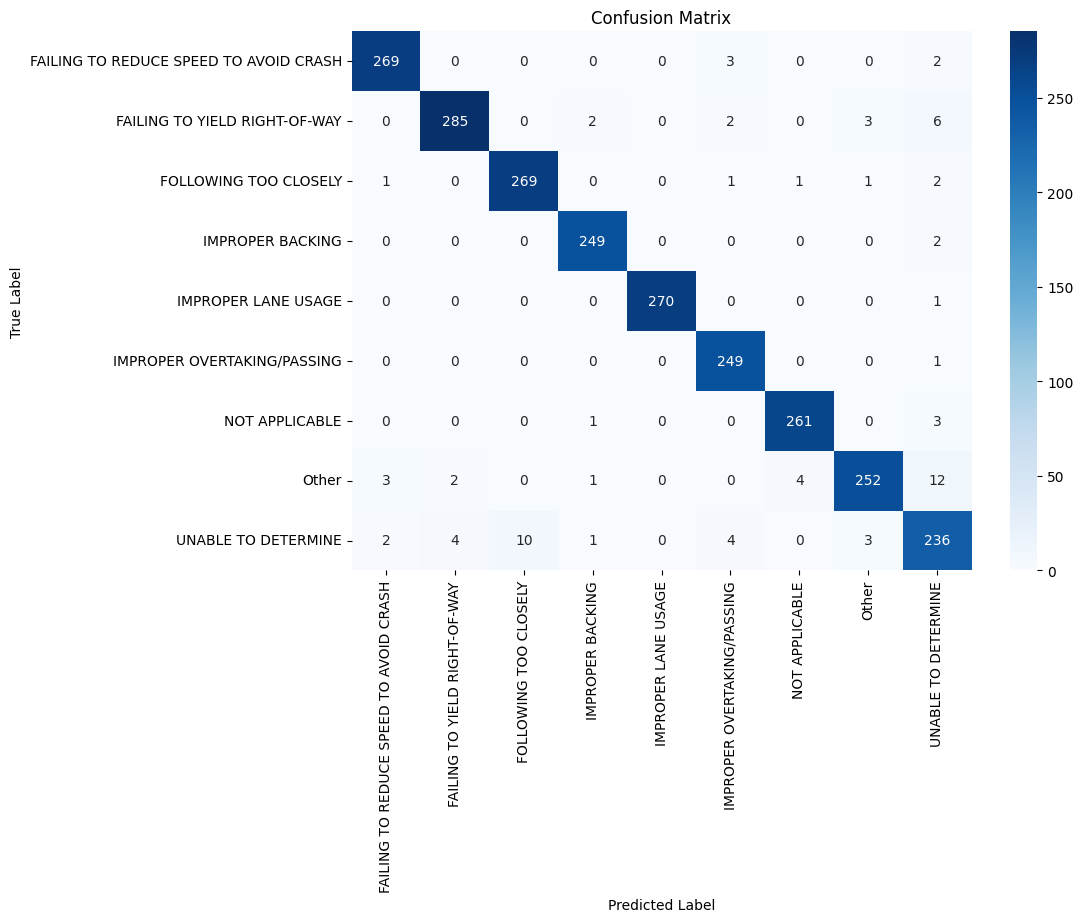

In [26]:
#visualizing the confusion matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
cm_rf = confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm_rf, le.classes_)



###  Train and Evaluate Logistic Regression Model

- Trained a Logistic Regression model on the balanced training data.
- Evaluated on the test set, results show:
  - **Accuracy:** ~55.2%, notably lower than the Random Forest.
  - **Precision, Recall, F1-score:** Weighted averages around 0.5, indicating moderate predictive ability.
- The classification report shows the model performs better on some classes (e.g., class 3) but struggles with others (e.g., class 8).
- The confusion matrix highlights misclassifications and class overlaps.
- Logistic Regression provides a baseline but is less effective than the Random Forest for this multi-class problem with complex features.


In [27]:
# logistic regression model
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)
# classification report for logistic regression
y_pred_logistic = logistic_model.predict(X_test)
print(" Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_logistic))
print("Precision:", precision_score(y_test, y_pred_logistic, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_logistic, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_logistic, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_logistic))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_logistic))


 Logistic Regression:
Accuracy: 0.5521091811414393
Precision: 0.5299044794375521
Recall: 0.5521091811414393
F1 Score: 0.5324920413335138
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.66      0.62       274
           1       0.57      0.61      0.59       298
           2       0.56      0.70      0.62       275
           3       0.63      0.73      0.68       251
           4       0.53      0.65      0.59       271
           5       0.58      0.71      0.64       250
           6       0.53      0.44      0.48       265
           7       0.51      0.35      0.41       274
           8       0.26      0.11      0.16       260

    accuracy                           0.55      2418
   macro avg       0.53      0.55      0.53      2418
weighted avg       0.53      0.55      0.53      2418

Confusion Matrix:
 [[182   6  33   5   4  13  16  10   5]
 [  9 182   8   6  36  15   4  27  11]
 [ 36   6 193   6   4   4  15   7   4

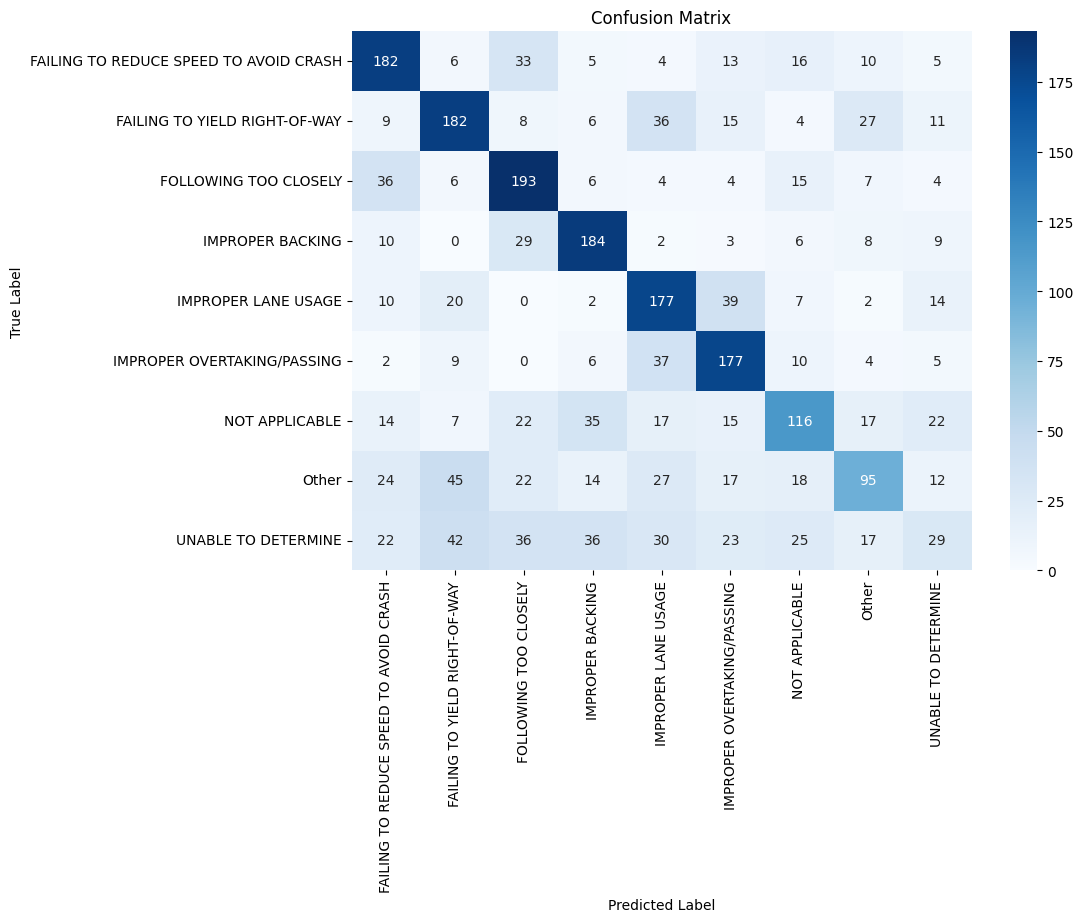

In [28]:
#Plot confusion matrix for logistic regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
plot_confusion_matrix(cm_logistic, le.classes_)

###  Train and Evaluate Decision Tree Model

- Trained a Decision Tree classifier on the balanced training data.
- On the test set, performance metrics are:
  - **Accuracy:** ~91.3%, better than Logistic Regression but below Random Forest.
  - **Precision & Recall:** Weighted averages around 0.91.
  - **F1 Score:** ~0.91, indicating moderate overall performance.
- The classification report shows good precision and recall for most classes, though class 8 remains challenging.
- The confusion matrix reveals where misclassifications occur, useful for further error analysis.
- Decision Tree provides a decent baseline with interpretable results but may benefit from tuning or ensemble methods (e.g., Random Forest).

If you want, I can help you with hyperparameter tuning, feature importance analysis, or trying other models!


In [29]:
#decision tree model
dt_model = DecisionTreeClassifier(random_state=42)      
dt_model.fit(X_train, y_train)
#classification report for decision tree
y_pred_dt = dt_model.predict(X_test)


print(" Decesion tree:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_dt, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_dt, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


 Decesion tree:
Accuracy: 0.9139784946236559
Precision: 0.9140600150441299
Recall: 0.9139784946236559
F1 Score: 0.9136177505120313
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93       274
           1       0.93      0.91      0.92       298
           2       0.94      0.95      0.95       275
           3       0.90      0.97      0.93       251
           4       0.96      0.94      0.95       271
           5       0.94      0.96      0.95       250
           6       0.90      0.90      0.90       265
           7       0.90      0.83      0.86       274
           8       0.83      0.82      0.83       260

    accuracy                           0.91      2418
   macro avg       0.91      0.91      0.91      2418
weighted avg       0.91      0.91      0.91      2418

Confusion Matrix:
 [[260   1   3   1   0   0   3   2   4]
 [  0 272   0   3   3   5   6   4   5]
 [  2   1 261   1   0   0   3   1   6]
 [  

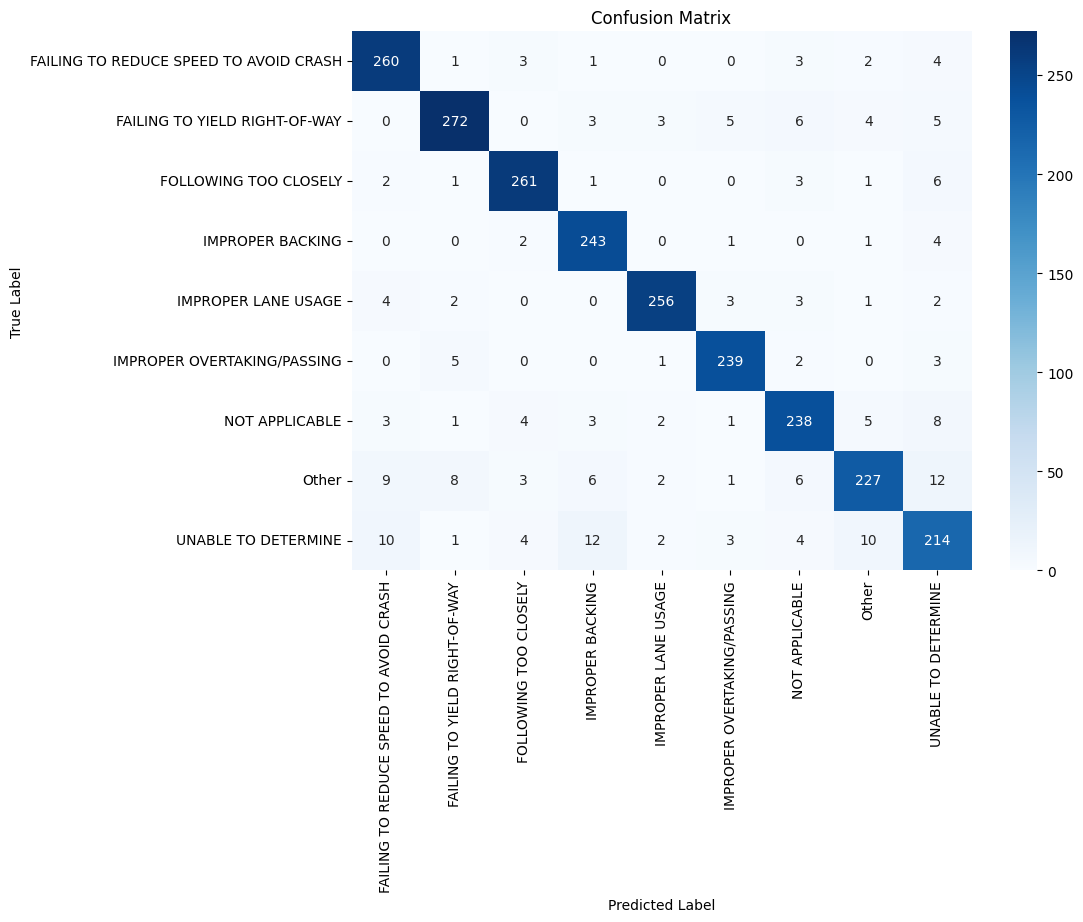

In [30]:
#plot confusion matrix for decision tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, le.classes_)

# XGBoost Model Performance

**Accuracy:** 0.95
**Precision (weighted):** 0.95
**Recall (weighted):** 0.95
**F1 Score (weighted):** 0.95

## Classification Report
*Shows strong precision, recall, and F1-score across most classes.*

## Confusion Matrix
*Highlights prediction strengths and areas for improvement.*


In [31]:
from xgboost import XGBClassifier

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)


# accuracy
print(" XGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))    
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

c:\Users\hezronkatila\anaconda3\envs\learn-env\lib\site-packages\xgboost\training.py:183: UserWarning: [11:28:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 XGBoost:
Accuracy: 0.956989247311828
Precision: 0.9580553623332492
Recall: 0.956989247311828
F1 Score: 0.9571941894591347
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       274
           1       0.95      0.94      0.94       298
           2       0.97      0.96      0.97       275
           3       0.98      0.98      0.98       251
           4       0.99      0.99      0.99       271
           5       0.98      0.99      0.99       250
           6       0.97      0.96      0.97       265
           7       0.95      0.89      0.92       274
           8       0.85      0.93      0.89       260

    accuracy                           0.96      2418
   macro avg       0.96      0.96      0.96      2418
weighted avg       0.96      0.96      0.96      2418

Confusion Matrix:
 [[267   3   0   0   0   0   0   0   4]
 [  0 279   0   1   1   3   2   3   9]
 [  1   0 265   0   0   1   1   3   4]
 [  1   0   

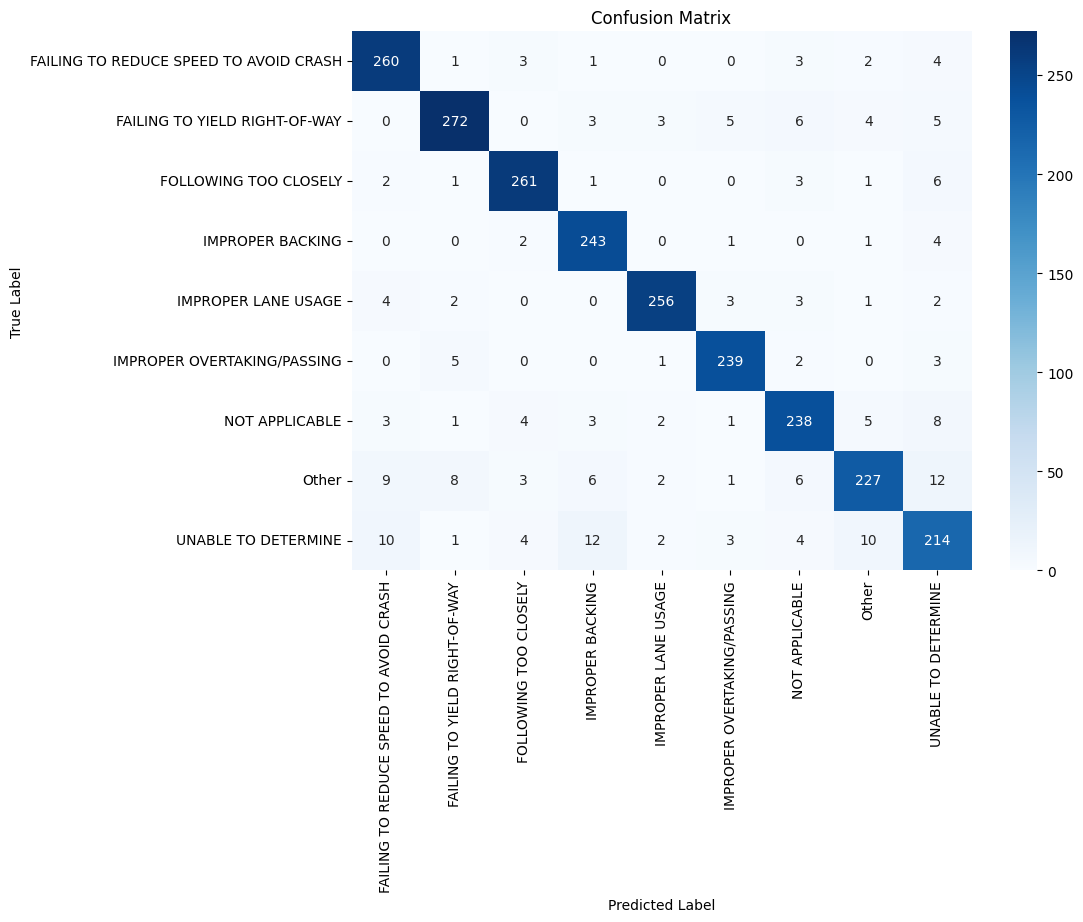

In [32]:
#plot confusion matrix for decision tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
plot_confusion_matrix(cm_dt, le.classes_)

###  Random Forest Optimization using GridSearchCV

To enhance the performance of our Random Forest classifier, I conducted hyperparameter tuning using `GridSearchCV`. The grid search explored the following parameter space:

- `n_estimators`: [100, 200]  
- `max_depth`: [10, 20, None]  
- `min_samples_split`: [2, 5]  
- `min_samples_leaf`: [1, 2]  
- `max_features`: ['sqrt', 'log2']

The model was evaluated using 5-fold cross-validation and accuracy as the scoring metric.

**Best Hyperparameters Found:**
```python
{ 'n_estimators': ..., 'max_depth': ..., 'min_samples_split': ..., 'min_samples_leaf': ..., 'max_features': ... }


In [33]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best parameters found: ", grid_search.best_params_)
y_pred_best = best_model.predict(X_test)
print(" Best Random Forest after Grid Search:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_best, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_best, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_best))



Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
 Best Random Forest after Grid Search:
Accuracy: 0.9698097601323408
Precision: 0.9700565908434822
Recall: 0.9698097601323408
F1 Score: 0.9697696643844396
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98       274
           1       0.98      0.96      0.97       298
           2       0.97      0.98      0.97       275
           3       0.98      0.99      0.99       251
           4       1.00      1.00      1.00       271
           5       0.96      1.00      0.98       250
           6       0.99      0.99      0.99       265
           7       0.98      0.92      0.95       274
           8       0.90      0.91      0.90       260

    accuracy                           0.97      2418
   macro avg       0.97     

## Confusion Matrix for Random Forest Classifier

The confusion matrix below illustrates the performance of the Random Forest model in predicting the contributory causes of car crashes. Each row represents the actual class, while each column represents the predicted class.

- **Diagonal values** indicate correct predictions.
- **Off-diagonal values** show misclassifications.
- Most contributory causes, such as:
  - *FAILING TO YIELD RIGHT-OF-WAY*,
  - *FOLLOWING TOO CLOSELY*,
  - *IMPROPER LANE USAGE*, and
  - *IMPROPER OVERTAKING/PASSING*  
  have high correct prediction counts (over 240 each), indicating strong model performance for these classes.

Notable observations:
- The "Other" and "UNABLE TO DETERMINE" classes show some misclassifications, especially across multiple categories.
- Despite minor misclassifications, the matrix suggests that the model performs well in distinguishing between the major contributory cause classes.

This visualization is useful for understanding class-level performance and identifying areas for potential improvement or class rebalancing.


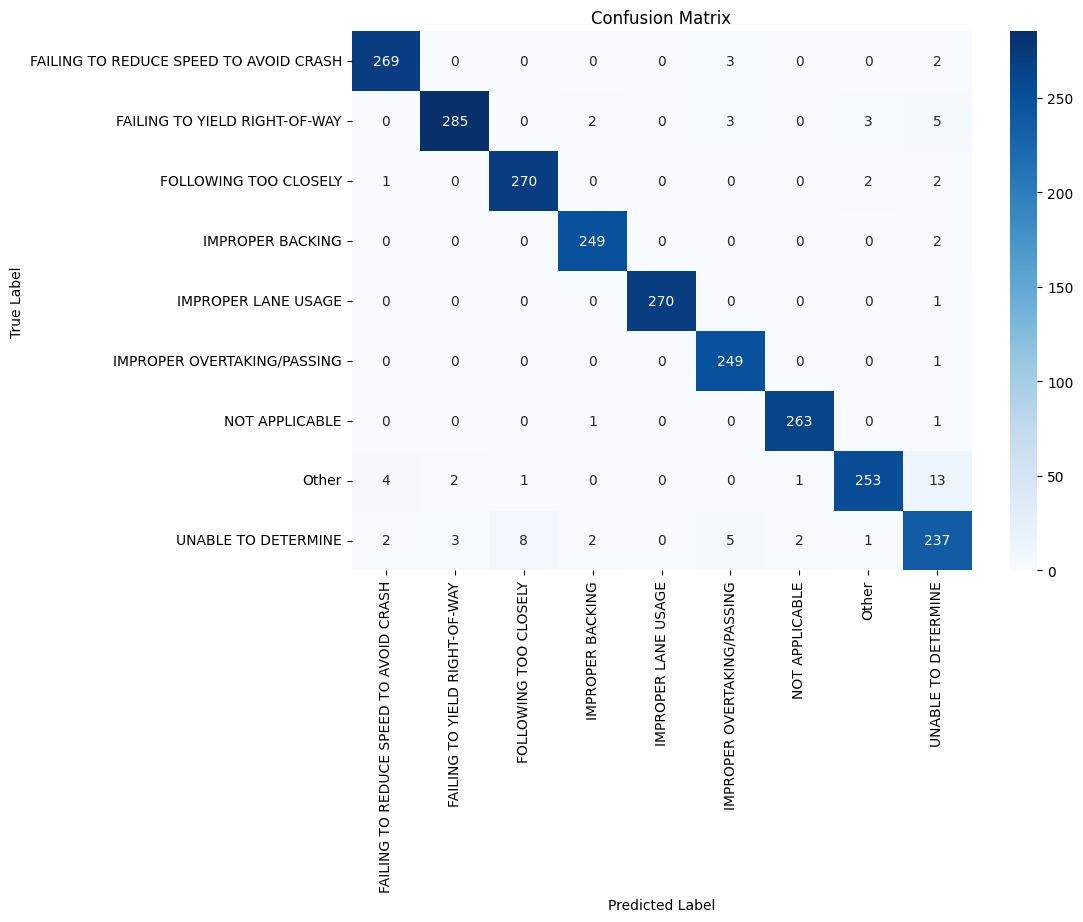

In [36]:
#plot confusion matrix for best random forest
cm_best_rf = confusion_matrix(y_test, y_pred_best)
plot_confusion_matrix(cm_best_rf, le.classes_)

##  Business Summary: Model Evaluation for Predicting Crash Causes

Tested four machine learning models to predict the **Primary Contributory Cause** of traffic crashes. This helps identify and address the top factors behind road accidents, enabling better safety strategies.

###  Best Performing Model: **Random Forest Classifier**

| Model                  | Accuracy | Business Impact |
|------------------------|----------|------------------|
| **Random Forest**      | 96.8%    |  Highly reliable predictions to support data-driven safety planning. |
| **XGBoost**            | 95.7%    |  Great performance, slightly below Random Forest. |
| **Decision Tree**      | 91.4%    |  Moderate accuracy, risk of misclassification. |
| **Logistic Regression**| 55.2%    |  Not suitable for business use due to low accuracy. |

---

###  Why Random Forest is Ideal for Business Use

- **High Accuracy**: It correctly predicts the root cause of accidents in nearly 97 out of 100 cases.
- **Robustness**: Works well even when the data has complex relationships or missing values.
- **Trustworthy Insights**: Helps prioritize interventions (e.g., improving road signage, driver training) based on the most frequent causes of crashes.

---

###  Business Value

Implementing this model can:
- Reduce accident rates by enabling **targeted preventive measures**.
- Improve **resource allocation** for law enforcement and road maintenance.
- Support **policy-making** with concrete data on what’s causing most crashes.

---

###  Recommendation

Adopt the **Random Forest model** for real-world deployment. Pair it with visual dashboards to provide stakeholders with clear, actionable insights on crash trends and causes.
